# Stock Market Sentiment Analysis

In [33]:
import pandas as pd
import numpy as np
import csv , re, string
import requests
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from textblob import TextBlob

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Importing the data

In [34]:
news = pd.read_csv('Combined_News_DJIA.csv')
stock = pd.read_csv('upload_DJIA_table.csv')

In [35]:
print('news dataset shape',news.shape)
print('stock dataset shape',stock.shape)

news dataset shape (1989, 27)
stock dataset shape (1989, 7)


In [36]:
dataset = pd.merge(news, stock, how='inner', on='Date', left_index=True)

In [37]:
headlines = list()
for row in range(len(dataset)):
    headlines.append(' '.join(str(elm) for elm in dataset.iloc[row,2:27]))
    pass
pass

# Data wrangling

In [38]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('b"', '', text)
    text = re.sub("b'", '', text)
    #text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [41]:
df = dataset.filter(['Label', 'Open', 'Close', 'High', 'Low'])
df['headlines'] = headlines

In [42]:
df

,Label,Open,Close,High,Low,headlines
1988,0,11432.089844,11734.320312,11759.959961,11388.040039,"b""Georgia 'downs two Russian warplanes' as cou..."
1987,1,11729.669922,11782.349609,11867.110352,11675.530273,b'Why wont America and Nato help us? If they w...
1986,0,11781.700195,11642.469727,11782.349609,11601.519531,b'Remember that adorable 9-year-old who sang a...
1985,0,11632.809570,11532.959961,11633.780273,11453.339844,b' U.S. refuses Israel weapons to attack Iran:...
1984,1,11532.070312,11615.929688,11718.280273,11450.889648,b'All the experts admit that we should legalis...
...,...,...,...,...,...,...
4,0,17355.210938,17140.240234,17355.210938,17063.080078,Barclays and RBS shares suspended from trading...
3,1,17190.509766,17409.720703,17409.720703,17190.509766,"2,500 Scientists To Australia: If You Want To ..."
2,1,17456.019531,17694.679688,17704.509766,17456.019531,Explosion At Airport In Istanbul Yemeni former...
1,1,17712.759766,17929.990234,17930.609375,17711.800781,Jamaica proposes marijuana dispensers for tour...


In [43]:
df['headlines'] = df['headlines'].apply(lambda x:clean_text_round1(x))
df['headlines'] = df['headlines'].apply(lambda x:clean_text_round2(x))

# Data engineering

In [44]:
df['headlines length'] = df['headlines'].apply(lambda x:len(x))

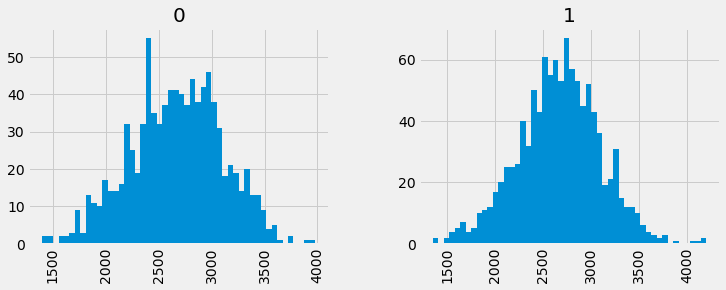

In [45]:
df.hist(column='headlines length', by='Label', bins=50,figsize=(12,4))
plt.show()

In [46]:
df['subjectivity'] = df['headlines'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['polarity']     = df['headlines'].apply(lambda x: TextBlob(x).sentiment.polarity)

Text(0, 0.5, '<-- Facts -------- Opinions -->')

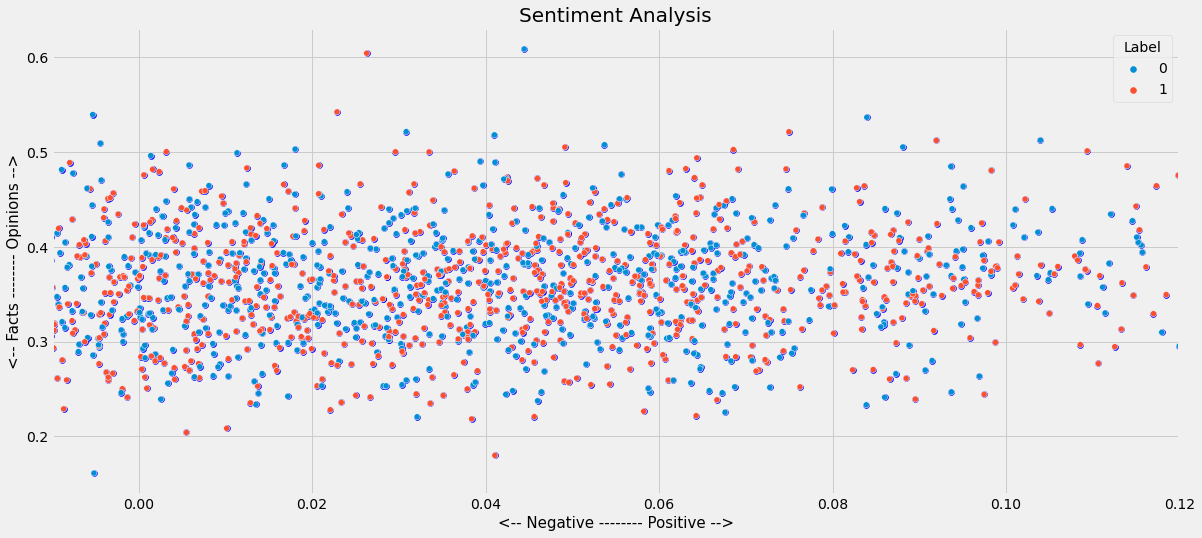

In [47]:
plt.figure(figsize = (18,8))
x = df.polarity
y = df.subjectivity
plt.scatter(x, y, color='blue')
sns.scatterplot(x=x, y=y, hue=df['Label'])
plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

In [48]:
analysis = df['headlines'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

In [49]:
for i in range(len(df)):
    df['sentiment'] = analysis[i]['compound']
    df['negative']  = analysis[i]['neg']
    df['neutre']    = analysis[i]['neu']
    df['positive']  = analysis[i]['pos']
    pass
pass

# Model Selection

In [50]:
X = df.drop(['Label', 'headlines', 'headlines length'], axis=1)
y = df.Label

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

## Logstic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print(lr.score(x_test, y_test))

0.9849246231155779


In [69]:
predictions = lr.predict(x_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       270
           1       0.98      0.99      0.99       327

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



## Linear Discriminant Analysis 

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [55]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train, y_train)
print(LDA.score(x_test, y_test))

0.7453936348408711


In [68]:
predictions = LDA.predict(x_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.44      0.61       270
           1       0.68      1.00      0.81       327

    accuracy                           0.75       597
   macro avg       0.84      0.72      0.71       597
weighted avg       0.83      0.75      0.72       597



### Support Vector Classifier

In [72]:
from sklearn.svm import SVC

In [73]:
SVC = SVC()
SVC.fit(x_train, y_train)
print(SVC.score(x_test, y_test))

0.5477386934673367


In [74]:
predictions = SVC.predict(x_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       270
           1       0.55      1.00      0.71       327

    accuracy                           0.55       597
   macro avg       0.27      0.50      0.35       597
weighted avg       0.30      0.55      0.39       597



C:\Users\Usurper\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Grid Search

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [80]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.530, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.530, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.532, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.529, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.529, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.530, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.530, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.532, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.529, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.529, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.534, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.540, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.529, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.522, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.692, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.699, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.629, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.860, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.864, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.835, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.817, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.838, total=   0.1s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   13.7s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [81]:
grid_predictions = grid.predict(x_test)
print(classification_report(y_test,grid_predictions))

NameError: name 'X_test' is not defined